# Laboratorio 3.7: Cuaderno del estudiante

## Información general

Este laboratorio es una continuación de los laboratorios guiados del Módulo 3.

En este laboratorio, creará un trabajo de ajuste de hiperparámetros para ajustar el modelo que creó anteriormente. A continuación, comparará las métricas de los dos modelos.


## Presentación de la situación empresarial

Trabaja para un proveedor de atención médica y desea mejorar la detección de anomalías en los pacientes de ortopedia. 

Se le asignó la tarea de resolver este problema con el uso de machine learning (ML). Tiene acceso a un conjunto de datos que contiene seis funciones biomecánicas y un objetivo de *normal* o *anormal*. Puede usar este conjunto de datos para entrenar un modelo de ML para predecir si un paciente tendrá una anomalía.


## Acerca de este conjunto de datos

Este conjunto de datos biomédicos fue creado por el Dr. Henrique da Mota durante un periodo de residencia médica en el Group of Applied Research in Orthopaedics (GARO) del Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, Francia. Los datos se organizaron en dos tareas de clasificación diferentes pero que se relacionan. 

La primera tarea consiste en clasificar pacientes como pertenecientes a una de tres categorías: 

- *Normal* (100 pacientes)
- *Hernia de disco* (60 pacientes)
- *Espondilolistesis* (150 pacientes)

Para la segunda tarea, las categorías *hernia de disco* y *espondilolistesis* se fusionaron en una sola categoría que se denomina *anormal*. Por ende, la segunda tarea consiste en clasificar a los pacientes como pertenecientes a una de dos categorías: *normal* (100 pacientes) o *anormal* (210 pacientes).


## Información de atributos

Cada paciente está representado en el conjunto de datos por seis atributos biomecánicos que se derivan de la forma y la orientación de la pelvis y la columna lumbar (en este orden): 

- Pelvic incidence (Incidencia pélvica)
- Pelvic tilt (Inclinación pélvica)
- Lumbar lordosis angle (Ángulo de lordosis lumbar)
- Sacral slope (Pendiente sacra)
- Pelvic radius (Radio pélvico)
- Grade of spondylolisthesis (Grado de espondilolistesis)

Se usa la siguiente convención para las etiquetas de clase: 
- DH (hernia de disco)
- SL (espondilolistesis)
- NO (normal) 
- AB (anormal)


Para obtener más información sobre este conjunto de datos, consulte la [página web del conjunto de datos de la columna vertebral](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).


## Atribuciones del conjunto de datos

Este conjunto de datos se obtuvo de:
Dua, D. y Graff, C. (2019). Repositorio de Machine Learning de UCI (http://archive.ics.uci.edu/ml). Irvine, CA: Universidad de California, School of Information and Computer Science.


# Configuración del laboratorio

Debido a que esta solución se divide en varios laboratorios en el módulo, debe ejecutar las siguientes celdas para poder cargar los datos y entrenar el modelo que se implementará.

**Nota:** La configuración puede tardar hasta 5 minutos en completarse.

## Importación de los datos y entrenamiento, prueba y validación del modelo

Ejecute las siguientes celdas para importar los datos, entrenar, probar y validar el modelo y dejarlo listo para utilizarse. 

**Nota:** Las siguientes celdas representan los pasos clave de los laboratorios anteriores.

Para ajustar el modelo, debe estar listo y, luego, se puede afinar con hiperparámetros en el paso 2.

In [1]:
bucket='c190240a4907842l13109963t1w471112804087-labbucket-ihdvjedek0n7'

In [2]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


**Nota:** La siguiente celda tarda aproximadamente **10** minutos en completarse. Observe el código y cómo se procesa, esto le permite entender mejor lo que sucede en segundo plano. Tenga presente que esta celda completa todos los pasos que hizo en laboratorios anteriores de este módulo, entre ellos:
 - Importación de los datos
 - Carga de los datos en un DataFrame
 - División de los datos en conjuntos de datos de entrenamiento, prueba y validación
 - Carga de los conjuntos de datos divididos en S3
 - Entrenamiento, prueba y validación del modelo con los conjuntos de datos

In [3]:
%%time

def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic",
             "silent" : 1}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-12-11-15-31-18-331



2025-12-11 15:31:20 Starting - Starting the training job..
2025-12-11 15:31:35 Starting - Preparing the instances for training..
2025-12-11 15:31:52 Downloading - Downloading input data..
2025-12-11 15:32:07 Downloading - Downloading the training image......
2025-12-11 15:32:43 Training - Training image download completed. Training in progress......
2025-12-11 15:33:14 Uploading - Uploading generated training model..
2025-12-11 15:33:27 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-12-11-15-33-30-333


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-12-11-15-33-30-940


.................................
..!
CPU times: user 1.83 s, sys: 150 ms, total: 1.98 s
Wall time: 8min 12s


# Paso 1: obtención de las estadísticas del modelo

Antes de ajustar el modelo, vuelva a familiarizarse con las métricas del modelo actual.

La configuración realizó una predicción por lotes, por lo que se deben leer los resultados desde Amazon Simple Storage Service (Amazon S3).

In [4]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]



Trace la matriz de confusión y la curva de la característica operativa del receptor (receiver operating characteristic, ROC) para el modelo original.


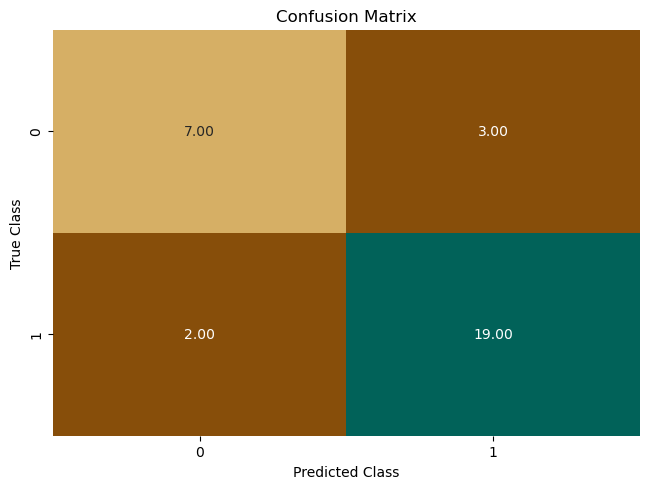

In [5]:
plot_confusion_matrix(test_labels, target_predicted_binary)

In [8]:
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
   # ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%
Validation AUC 0.8023809523809523
Figure(640x480)


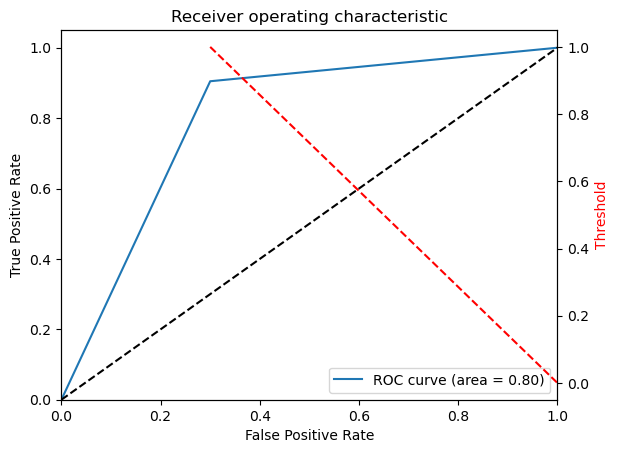

<Figure size 640x480 with 0 Axes>

In [9]:
plot_roc(test_labels, target_predicted_binary)

Este gráfico le ofrece un punto de partida. Tome nota de la *Validation area under the curve (AUC)* (Área bajo la curva de validación). La usará más adelante para comprobar si su modelo ajustado es mejor. 

# Paso 2: creación de un trabajo de ajuste de hiperparámetros

Un trabajo de ajuste de hiperparámetros puede tardar varias horas en completarse, dependiendo de los rangos de valores que le proporcione. Para simplificar esta tarea, los parámetros utilizados en este paso son un subconjunto de los rangos recomendados. Se ajustaron para dar buenos resultados en este laboratorio, sin que hagan falta varias horas para completarlo.

Para obtener más información sobre los parámetros para ajustar en XGBoost, consulte [Tune an XGBoost Model (Ajustar un modelo de XGBoost)](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) en la documentación de AWS.

Ya que la siguiente celda puede tardar alrededor de **45** minutos en completarse, continúe y ejecute la celda. Examinará lo que sucede y por qué se eligieron estos rangos de hiperparámetros.

In [10]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


xgb.set_hyperparameters(eval_metric='error@.40',
                        objective='binary:logistic',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-251211-1547


...............................................................................................................................................!
!
CPU times: user 887 ms, sys: 16.9 ms, total: 904 ms
Wall time: 12min 24s


En primer lugar, creará el modelo que desea ajustar.

```
xgb = sagemaker.estimator.Estimator(container,
                                   role=sagemaker.get_execution_role(), 
                                   instance_count= 1, # asegúrese de configurar un límite para estas instancias
                                   instance_type='ml.m4.xlarge', 
                                   output_path='s3://{}/{}/output'.format(bucket, prefix),
                                   sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(eval_metric='[error@.40]',
                        objective='binary:logistic',
                        num_round=42)

```                        

Observe que *eval_metric* del modelo cambió a *error@.40*, con el objetivo de minimizar ese valor. 

**error** es la tasa de error de clasificación binaria. Se calcula como *#(wrong cases)/#(all cases)*. Para las predicciones, la evaluación considerará las instancias que tienen un valor de predicción mayor que 0,4 para ser instancias positivas y las demás son instancias negativas.

A continuación, debe especificar los hiperparámetros que desea ajustar, además de los rangos que debe seleccionar para cada parámetro.

Los hiperparámetros que tienen el mayor efecto en las métricas objetivo de XGBoost son: 

- alpha
- min_child_weight
- subsample
- eta
- num_round 

Puede encontrar los rangos de ajuste recomendados en la documentación de AWS en [Tune an XGBoost Model (Ajustar un modelo de XGBoost)](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html).

Para este laboratorio, usará un *subconjunto* de valores. Estos valores se obtuvieron ejecutando el trabajo de ajuste con el rango completo, luego, minimizando el rango para que se puedan usar menos iteraciones y obtener un mejor rendimiento. Aunque esta práctica no es estrictamente realista, evita que espere varias horas a que se complete el trabajo de ajuste en este laboratorio.

```
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }
```


Debe especificar cómo evaluará el modelo. Podría usar varias métricas objetivo distintas, de las que un subconjunto se aplica a un problema de clasificación binaria. Como la métrica de evaluación es **error**, configure el objetivo en *error*.

```
objective_metric_name = 'validation:error'
objective_type = 'Minimize'
```

Por último, ejecute el trabajo de ajuste.

```
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Configure esto en 10 o más dependiendo del presupuesto y tiempo disponible.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()
```



<i class="fas fa-exclamation-triangle" style="color:red"></i> Espere a que finalice el trabajo de entrenamiento. Esto podría tardar hasta **45** minutos. Mientras espera, observe el estado del trabajo en la consola, según se describe en las siguientes instrucciones.

**Para supervisar los trabajos de optimización de hiperparámetros:**  

1. En la Consola de administración de AWS, en el menú **Servicios**, haga clic en **Amazon SageMaker**.  
2. Elija **Entrenamiento > Trabajos de ajuste de hiperparámetros**.  
3. Puede revisar el estado de cada trabajo de ajuste de hiperparámetros, su valor de métrica objetiva y sus registros.  

Después de que finalice el trabajo de entrenamiento, revise el trabajo y asegúrese de que se completó correctamente.

In [11]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

# Paso 3: investigación de los resultados del trabajo de ajuste

Ahora que se completó el trabajo, debe haber 10 trabajos completados. Uno de los trabajos debe marcarse como el mejor.

Puede examinar las métricas obteniendo *HyperparameterTuningJobAnalytics* y cargando esos datos en un DataFrame de pandas.


In [12]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,1.205383,0.169236,3.391668,34.0,0.834064,sagemaker-xgboost-251211-1547-008-d32a569e,Completed,0.12903,2025-12-11 15:55:14+00:00,2025-12-11 15:55:47+00:00,33.0
4,9.103201,0.147991,2.090671,14.0,0.549404,sagemaker-xgboost-251211-1547-006-8c7ca08d,Completed,0.12903,2025-12-11 15:53:32+00:00,2025-12-11 15:54:06+00:00,34.0
5,18.911981,0.128838,1.766759,15.0,0.583763,sagemaker-xgboost-251211-1547-005-94300777,Completed,0.19355,2025-12-11 15:52:42+00:00,2025-12-11 15:53:16+00:00,34.0
0,37.071125,0.191020,1.408907,49.0,0.612540,sagemaker-xgboost-251211-1547-010-4808a3d2,Completed,0.22581,2025-12-11 15:57:15+00:00,2025-12-11 15:59:10+00:00,115.0
6,43.098015,0.178321,3.267714,30.0,0.758604,sagemaker-xgboost-251211-1547-004-a7b7b1b2,Completed,0.22581,2025-12-11 15:51:57+00:00,2025-12-11 15:52:31+00:00,34.0
7,21.988725,0.226158,3.720321,33.0,0.542300,sagemaker-xgboost-251211-1547-003-5b07f0b2,Completed,0.22581,2025-12-11 15:51:13+00:00,2025-12-11 15:51:47+00:00,34.0
1,35.537553,0.210026,4.239196,25.0,0.500762,sagemaker-xgboost-251211-1547-009-95348a78,Stopped,0.67742,2025-12-11 15:56:04+00:00,2025-12-11 15:56:26+00:00,22.0
3,100.000000,0.146730,1.702709,44.0,0.514578,sagemaker-xgboost-251211-1547-007-88d6844d,Completed,0.67742,2025-12-11 15:54:24+00:00,2025-12-11 15:54:58+00:00,34.0
8,72.745365,0.188359,4.937165,21.0,0.859709,sagemaker-xgboost-251211-1547-002-b6d11902,Completed,0.67742,2025-12-11 15:50:28+00:00,2025-12-11 15:51:02+00:00,34.0
9,58.769005,0.141488,3.727908,24.0,0.515355,sagemaker-xgboost-251211-1547-001-a380bae4,Completed,0.67742,2025-12-11 15:48:03+00:00,2025-12-11 15:49:58+00:00,115.0


Debe poder ver los hiperparámetros que se usaron para cada trabajo, junto con la puntuación. Podría usar esos parámetros y crear un modelo, o puede obtener el mejor modelo a partir del trabajo de ajuste de hiperparámetros.

In [13]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Ahora debe adjuntar el mejor trabajo de entrenamiento y crear el modelo.

In [14]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml

2025-12-11 15:54:23 Starting - Found matching resource for reuse
2025-12-11 15:54:23 Downloading - Downloading the training image
2025-12-11 15:54:23 Training - Training image download completed. Training in progress.
2025-12-11 15:54:23 Uploading - Uploading generated training model
2025-12-11 15:54:23 Completed - Resource reused by training job: sagemaker-xgboost-251211-1547-007-88d6844d


Luego, puede usar el método de transformación para realizar una predicción por lotes con sus datos de pruebas. Recuerde que los datos de pruebas son aquellos que el modelo nunca ha visto antes.

In [15]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-12-11-16-08-04-418
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-12-11-16-08-04-949


.......................................
..!
CPU times: user 1.08 s, sys: 31.2 ms, total: 1.11 s
Wall time: 6min 58s


Obtenga el objetivo que se predijo y las etiquetas de prueba del modelo.

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
best_target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = best_target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

Trace una matriz de confusión para `best_target_predicted` y `test_labels`.

In [ ]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

Trace el gráfico ROC:

In [ ]:
plot_roc(test_labels, best_target_predicted_binary)

**Pregunta:** ¿En qué se diferencian estos resultados del original? ¿Estos resultados son mejores o peores? 

Podría no ver siempre una mejora. Este resultado se debe a algunas razones:

- El modelo podría ya ser bueno desde la pasada inicial (lo que se considera como *bueno* es subjetivo).
- No tiene una gran cantidad de datos con los que entrenar.
- Usa un *subconjunto* de los rangos de ajuste de hiperparámetros para ahorrarse tiempo en este laboratorio.

Aumentar los rangos de hiperparámetros (como se recomienda en la documentación) y ejecutar más de 30 trabajo normalmente mejorará el modelo. Sin embargo, este proceso tardará entre 2 y 3 horas en completarse.

# ¡Felicitaciones!

Completó este laboratorio y ahora puede finalizarlo siguiendo las instrucciones en la guía del laboratorio.


